In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import

In [2]:
data = pd.read_csv('train_CalSA.csv')
submission = pd.read_csv('test_tmlcc.csv')

data.shape, submission.shape

((68613, 15), (17000, 13))

# Eda

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68613 entries, 0 to 68612
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              68613 non-null  object 
 1   vol               68613 non-null  float64
 2   weight            68613 non-null  float64
 3   density [g/cm^3]  68613 non-null  float64
 4   SA                68613 non-null  float64
 5   VF                68613 non-null  float64
 6   VV                68613 non-null  float64
 7   FG                68290 non-null  object 
 8   ML                68613 non-null  int64  
 9   OL1               68613 non-null  int64  
 10  OL2               68613 non-null  int64  
 11  TP                68613 non-null  object 
 12  CO2/N2            68613 non-null  float64
 13  Heat              66526 non-null  float64
 14  CO2W              68613 non-null  float64
dtypes: float64(9), int64(3), object(3)
memory usage: 7.9+ MB


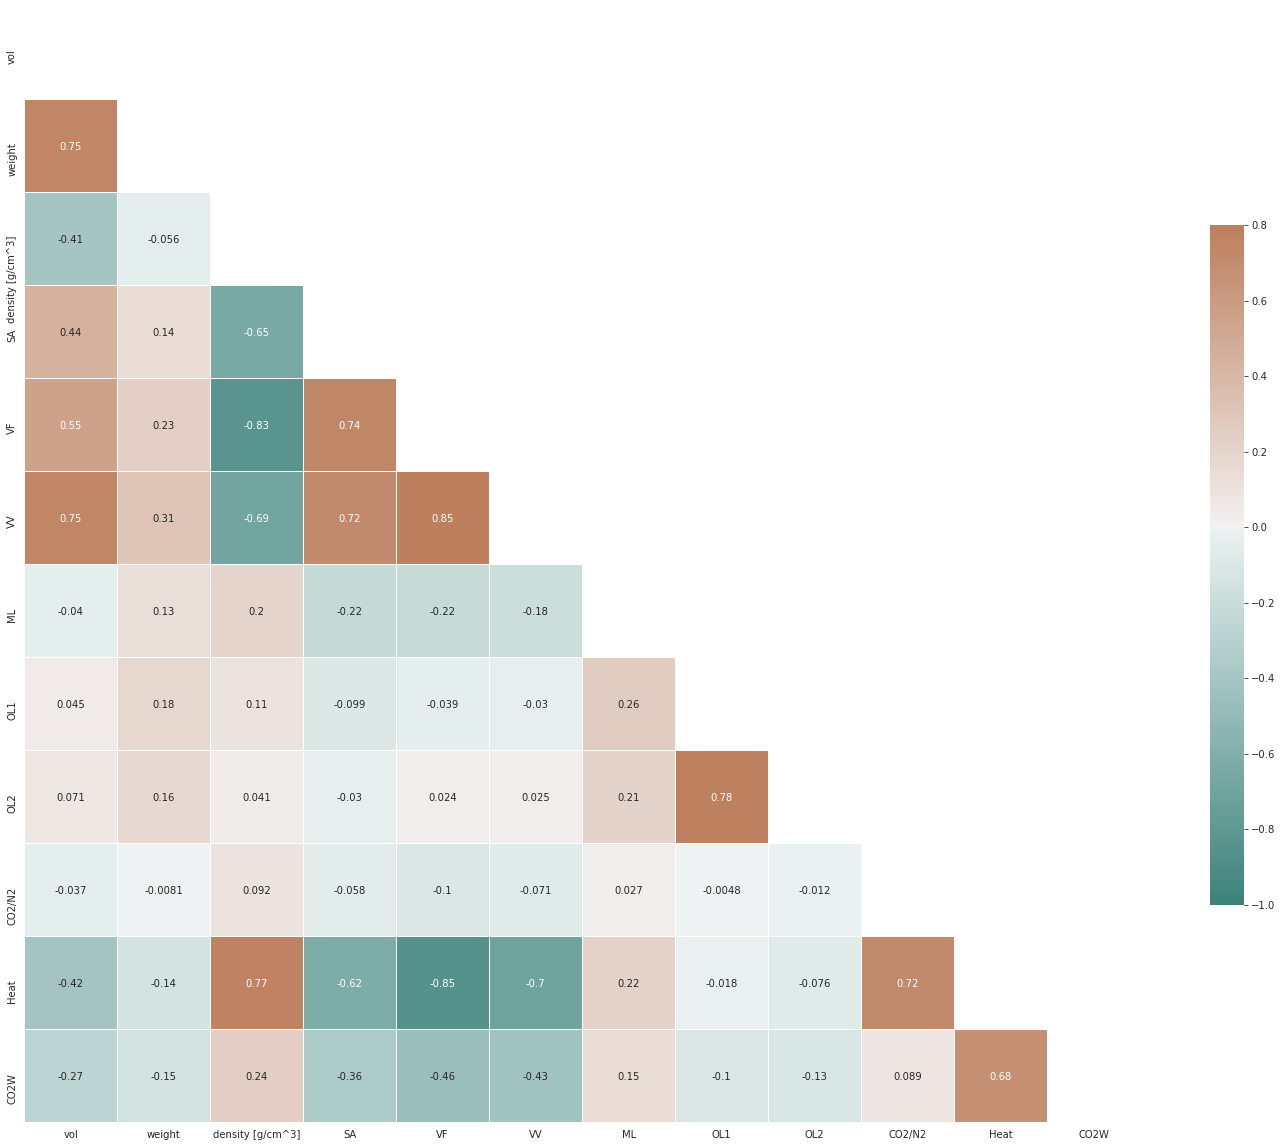

In [4]:
corr = data.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True

cmap = sns.diverging_palette(180, 30, as_cmap=True)

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(25, 25))
    sns.heatmap(corr,  mask=mask, cmap=cmap, annot=True, center=0, vmin=-1, vmax=0.8,
                square=True, cbar_kws={'shrink':.5, 'orientation': 'vertical'}, linewidth=.02);

In [5]:
corr = data.corr()

corr['CO2W'].sort_values(ascending=False)[:].to_frame()\
.style.background_gradient(axis=1,cmap=sns.light_palette('green', as_cmap=True))

,CO2W
CO2W,1.000000
Heat,0.678997
density [g/cm^3],0.243546
ML,0.146671
CO2/N2,0.089437
OL1,-0.104201
OL2,-0.127834
weight,-0.153225
vol,-0.272370
SA,-0.363283


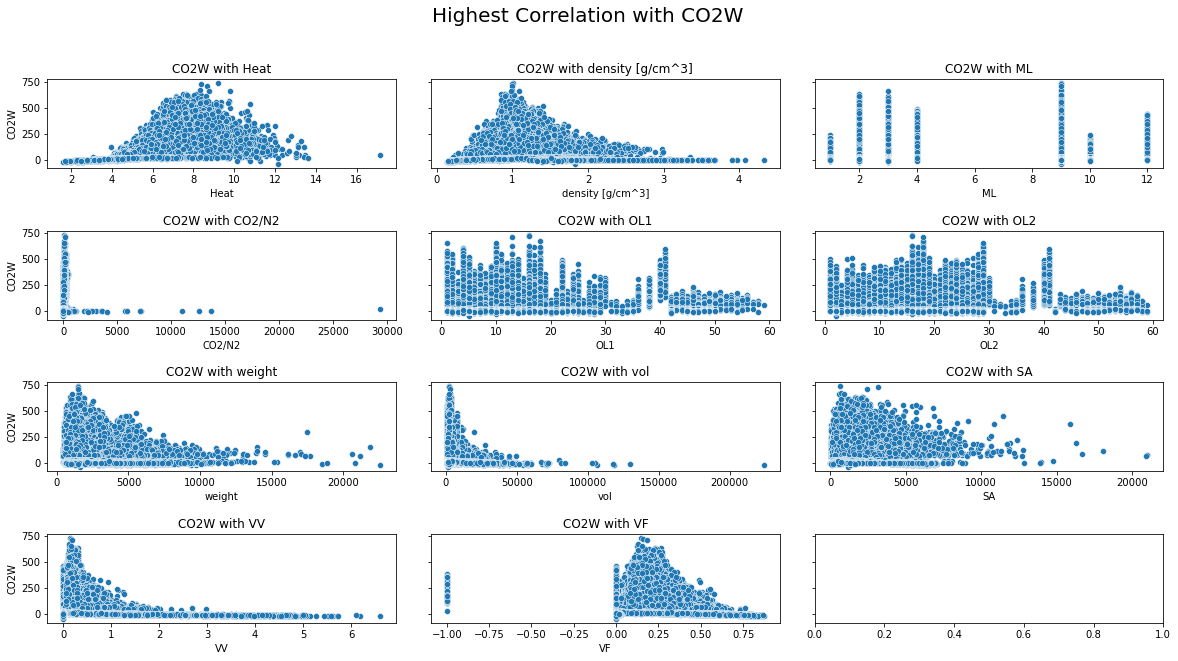

In [6]:
high_corr = corr['CO2W'].sort_values(ascending=False)[1:][:13].index.tolist()

fig, axes = plt.subplots(4,3, figsize=(20, 10), sharey=True);
plt.subplots_adjust(hspace = 0.7, wspace=0.1)
fig.suptitle('Highest Correlation with CO2W', fontsize=20)

for i,col in zip(range(15),high_corr):
    sns.scatterplot(y=data['CO2W'], x=data[col],ax=axes[i//3][i%3])
    axes[i//3][i%3].set_title('CO2W with '+col)

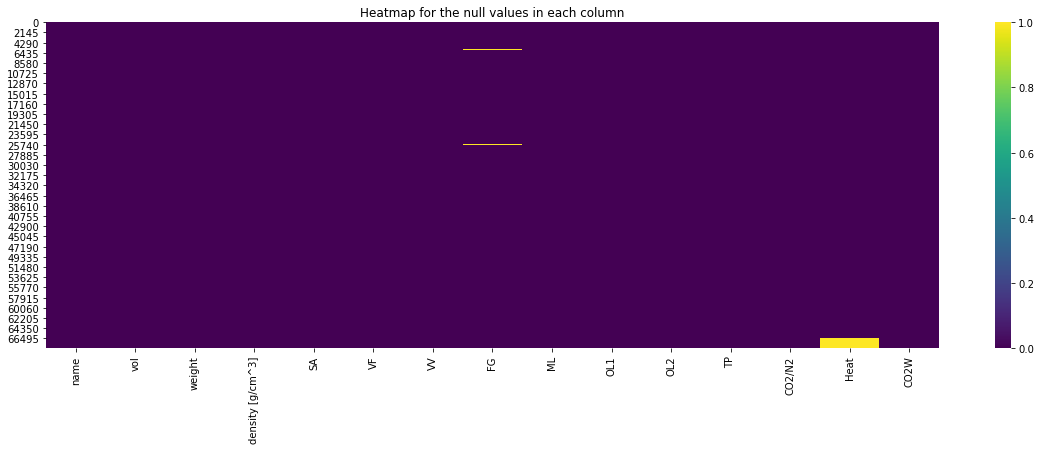

In [7]:
plt.figure(figsize=(20,6))
plt.title('Heatmap for the null values in each column')
sns.heatmap(data.isnull(),cmap='viridis');

In [8]:
data_null = round(100*(data.isnull().sum().sort_values(ascending=False)/len(data.index)),2)\
                    .to_frame().rename(columns={0:'Null values percentage'})[:15]
data_null

,Null values percentage
Heat,3.04
FG,0.47
name,0.00
vol,0.00
weight,0.00
density [g/cm^3],0.00
SA,0.00
VF,0.00
VV,0.00
ML,0.00


In [9]:
# drop name, null, outline

data = data.drop(columns=['name', 'density [g/cm^3]'])

data = data.dropna()

drop_index = data[((data['CO2W']<0) & (data['Heat']>16))|
                  ((data['CO2/N2']>5000) & (data['vol']>200000))|
                  ((data['VF']<0))].index

data = data.drop(drop_index)

# Data prepare

In [10]:
formula_size = 100000
max_length = 32

In [11]:
def prepare_data(X):

    FG_feature = X.pop('FG')
#     FG_feature = X.pop('functional_groups')
    
    X = pd.get_dummies(X, columns=['TP'])
#     X = pd.get_dummies(X, columns=['topology'])

    X_features = X.astype('float32')
    
    X_features = np.array(X_features)
    FG_feature = np.array(FG_feature)
    
    encoded_FG = [one_hot(w, formula_size) for w in FG_feature]
    padded_FG = pad_sequences(encoded_FG, maxlen=max_length, padding='post')
            
    FG_feature = padded_FG
    
    return X_features, FG_feature

In [12]:
train, val = train_test_split(data, test_size=0.3)

In [13]:
X_train = train.copy()
Y_train = X_train.pop('CO2W')

X_val = val.copy()
Y_val = X_val.pop('CO2W')

In [14]:
X_features, FG_feature = prepare_data(X_train)
Y_train = np.array(Y_train)

In [15]:
X_features.shape, FG_feature.shape

((46305, 21), (46305, 32))

# Model

In [16]:
sequence_length = 100

embedding_dim = 16

In [30]:
X_input = keras.Input(shape=(21,), name="X")
FG_input = keras.Input(shape=(None,), name="FG")

norm = preprocessing.Normalization()
norm.adapt(X_features[1,:])
X_norm = norm(X_input)

vectorize_layer = TextVectorization(
    standardize=FG_feature,
    max_tokens=formula_size,
    output_mode='int',
    output_sequence_length=sequence_length)
vectorize_layer.adapt(FG_feature.batch(batch_norm))

FG_Embedding = layers.Embedding(formula_size, 32)(FG_input)

FG_lstm = layers.LSTM(16)(FG_Embedding)

x = layers.concatenate([X_norm , FG_lstm])
# x = layers.concatenate([X_input, FG_feature])
x = layers.Dense(128,activation='relu')(x)
x = layers.Dense(64,activation='relu')(x)

CO2w = layers.Dense(1,activation='linear')(x)

model = keras.Model(
    inputs=[X_input, FG_input],
    outputs=CO2w,
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001),
    loss=tf.keras.losses.MeanSquaredLogarithmicError()
)

model.fit(
    {"X": X_features, "FG" : FG_feature},
    Y_train,
    epochs=10,
    batch_size=512,
)

Epoch 1/10
91/91 [==============================] - 3s 19ms/step - loss: nan
Epoch 2/10
91/91 [==============================] - 2s 19ms/step - loss: nan
Epoch 3/10
91/91 [==============================] - 2s 19ms/step - loss: nan
Epoch 4/10
91/91 [==============================] - 2s 20ms/step - loss: nan
Epoch 5/10
91/91 [==============================] - 2s 19ms/step - loss: nan
Epoch 6/10
91/91 [==============================] - 2s 20ms/step - loss: nan
Epoch 7/10
91/91 [==============================] - 2s 19ms/step - loss: nan
Epoch 8/10
91/91 [==============================] - 2s 20ms/step - loss: nan
Epoch 9/10
91/91 [==============================] - 2s 19ms/step - loss: nan
Epoch 10/10
91/91 [==============================] - 2s 20ms/step - loss: nan


In [19]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# Test

In [ ]:
def prepare_test(X):

#     FG_feature = X.pop('FG')
    FG_feature = X.pop('functional_groups')
    
#     X = pd.get_dummies(X, columns=['TP'])
    X = pd.get_dummies(X, columns=['topology'])

    X_features = X.astype('float32')
    
    X_features = np.array(X_features)
    FG_feature = np.array(FG_feature)
    
    encoded_FG = [one_hot(w, formula_size) for w in FG_feature]
    padded_FG = pad_sequences(encoded_FG, maxlen=max_length, padding='post')
            
    FG_feature = padded_FG
    
    return X_features, FG_feature

In [ ]:
mof = submission.pop('MOFname')

In [ ]:
X_2, FG_2 = prepare_test(submission)

In [ ]:
X_2.shape

In [ ]:
y = model.predict({"X": X_2, "FG" : FG_2})